In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import random
import numpy as np
from seirsplus.networks import generate_demographic_contact_network, household_country_data
from seirsplus.viral_model import ViralExtSEIRNetworkModel
from seirsplus.sim_loops_pooled_test import SimulationRunner

In [3]:
import pickle

NUM_TRIALS = 50

param_to_vary = "pool_size"
# param_to_vary = "init_prev"

param_config = {
    "pop_size_default": 10000,

    "init_prev": [0.001, 0.005, 0.01, 0.05, 0.1],
    "init_prev_default": 0.01,

    'horizon_default': 100,

    "num_groups": [5, 10, 20],
    'num_groups_default': 10,

    "pool_size": [5, 10, 15, 20, 25, 30],
    "pool_size_default": 5,

    "beta_default": 0.5, # transmissibility
    "sigma_default": 0.2, # rate E --> I_pre
    "lamda_default": 0.5, # rate I_pre --> I_(a)sym
    "gamma_default": 0.25 # rate I_sym --> R
}

paths = {}


for param_val in param_config[param_to_vary]:
    path = "../results/US"

    for param_name in [
        "pop_size", "init_prev", "num_groups", "pool_size", "horizon", 
        "beta", "sigma", "lamda", "gamma"
    ]:
            
        if param_name == param_to_vary:
            path += f"_{param_name}={param_val}"
        else:
            path += f"_{param_name}={param_config[param_name+'_default']}"
        
    paths[param_val] = path



In [4]:
paths

{5: '../results/US_pop_size=10000_init_prev=0.01_num_groups=10_pool_size=5_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25',
 10: '../results/US_pop_size=10000_init_prev=0.01_num_groups=10_pool_size=10_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25',
 15: '../results/US_pop_size=10000_init_prev=0.01_num_groups=10_pool_size=15_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25',
 20: '../results/US_pop_size=10000_init_prev=0.01_num_groups=10_pool_size=20_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25',
 25: '../results/US_pop_size=10000_init_prev=0.01_num_groups=10_pool_size=25_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25',
 30: '../results/US_pop_size=10000_init_prev=0.01_num_groups=10_pool_size=30_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25'}

In [5]:
from collections import defaultdict
def defaultdict_list():
    return defaultdict(list)

results = defaultdict(defaultdict_list) # dict of dict of list of individual results

for param_val, path in paths.items():
    for pooling_strategy in ["naive", "correlated"]:
        for i in range(NUM_TRIALS):
            filepath = path + f"/{pooling_strategy}/results_{i}.pickle"
            try:
                with open(filepath, "rb") as f:
                    results[pooling_strategy][param_val].append(pickle.load(f))
            except:
                continue


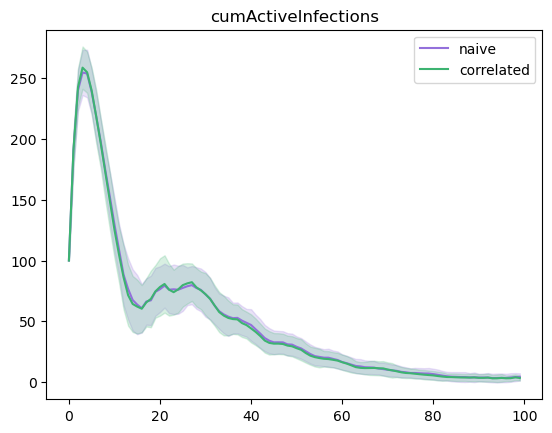

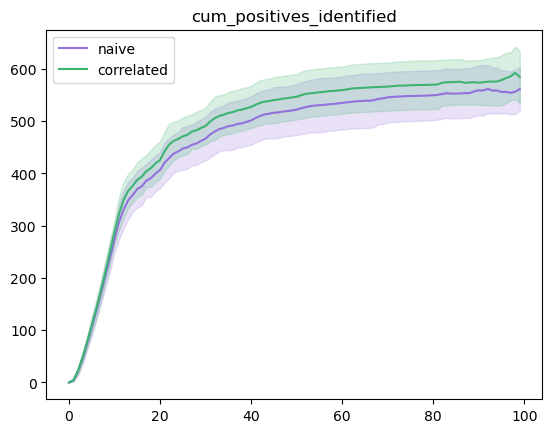

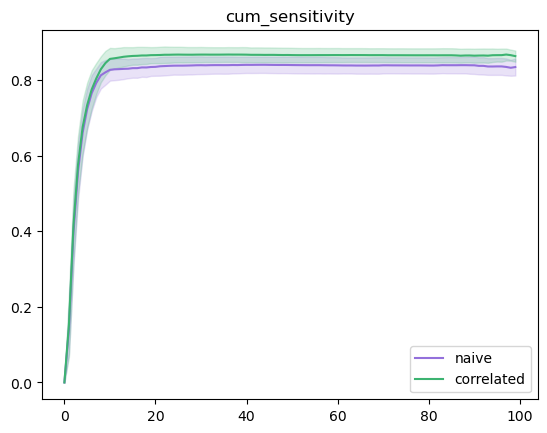

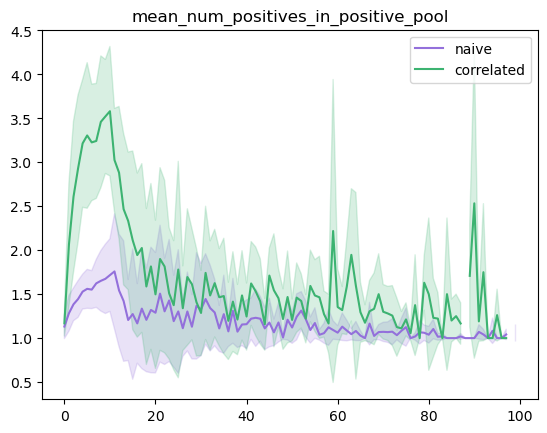

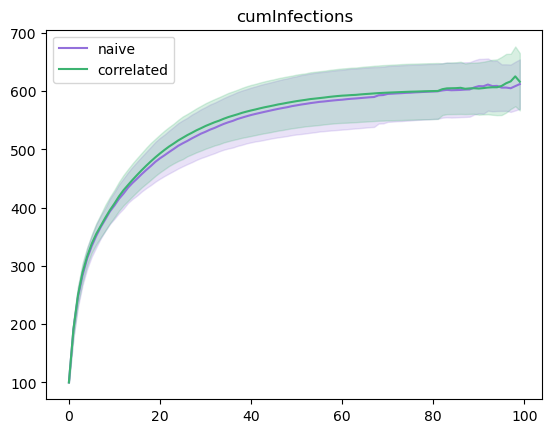

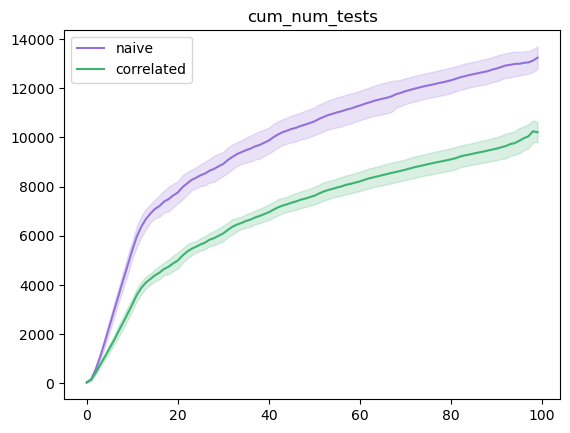

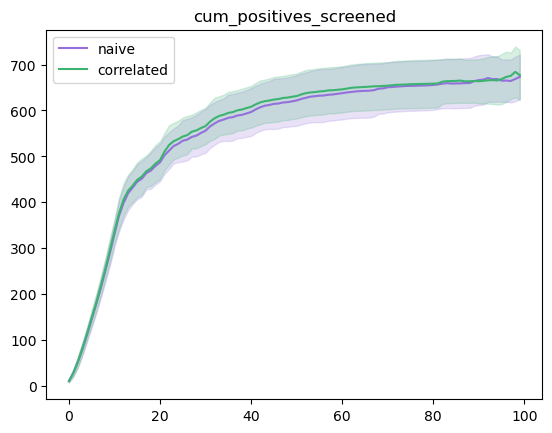

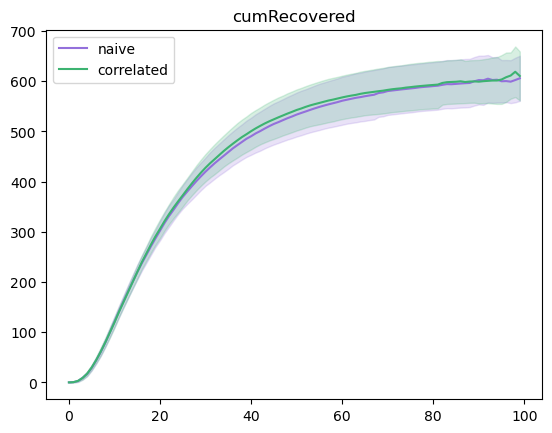

In [39]:
# PARAM_VAL = 0.05
PARAM_VAL= 30
metrics = set(results["correlated"][PARAM_VAL][0][0].keys()) - set(["day"])

for metric in metrics:

    naive_results = []
    correlated_results = []

    # for SEED in range(5):
    for SEED in range(len(results["correlated"][PARAM_VAL])):

        naive_results.append(
            [x[metric]\
            for x in results["naive"][PARAM_VAL][SEED]]
        )
        correlated_results.append(
            [x[metric]\
            for x in results["correlated"][PARAM_VAL][SEED]]
        )

    naive_results_ = np.array([xi+[None]*(100-len(xi)) for xi in naive_results], dtype=float)
    correlated_results_ = np.array([xi+[None]*(100-len(xi)) for xi in correlated_results], dtype=float)

    naive_mean = np.nanmean(naive_results_, axis=0)
    naive_std = np.nanstd(naive_results_, axis=0)
    correlated_mean = np.nanmean(correlated_results_, axis=0)
    correlated_std = np.nanstd(correlated_results_, axis=0)

    plt.plot(naive_mean, color="mediumpurple", label="naive")
    plt.fill_between(
        range(len(naive_mean)),
        naive_mean-naive_std,
        naive_mean+naive_std,
        alpha=0.2,
        color="mediumpurple"
    )

    plt.plot(correlated_mean, color="mediumseagreen", label="correlated")
    plt.fill_between(
        range(len(correlated_mean)),
        correlated_mean-correlated_std,
        correlated_mean+correlated_std,
        alpha=0.2,
        color="mediumseagreen"
    )

    plt.title(metric)
    plt.legend()
    plt.show()

In [64]:
agg_results_raw = defaultdict(defaultdict_list)

# number of pos in positive pool
# for metric in ["cum_sensitivity", "cum_num_tests", "cumInfections"]:
metric = "cumInfections"
for param_val in paths.keys():
    for i in range(10):
        for pooling_strategy in ["naive", "correlated"]:
            agg_results_raw[pooling_strategy][param_val].append(results[pooling_strategy][param_val][i][-1][metric])


In [50]:
agg_results = defaultdict(defaultdict_list)

for pooling_strategy in ["naive", "correlated"]:
    for param_val in paths.keys():
        agg_results[pooling_strategy][param_val] =\
            [np.mean(agg_results_raw[pooling_strategy][param_val]),
                np.std(agg_results_raw[pooling_strategy][param_val])]

In [66]:
agg_results_diff = {}

for param_val in paths.keys():
    tmp =\
        np.array(agg_results["correlated"][param_val]) - np.array(agg_results["naive"][param_val])
    agg_results_diff[param_val] = np.mean(tmp), np.std(tmp)

In [67]:
agg_results_diff

{0.001: (-17.929261900009244, 0.7292619000092433),
 0.005: (-5.014545572855866, 11.785454427144145),
 0.01: (-4.986340831431846, 3.086340831431869),
 0.05: (-6.1910415476082346, 6.0910415476083255),
 0.1: (5.484804006144021, 5.115195993855888)}

In [51]:
agg_results

defaultdict(<function __main__.defaultdict_list()>,
            {'naive': defaultdict(list,
                         {0.001: [89.0, 46.48225467853297],
                          0.005: [344.8, 51.32211998738945],
                          0.01: [581.9, 54.074855524541164],
                          0.05: [2138.4, 36.34886518173573],
                          0.1: [3564.0, 59.66238345892661]}),
             'correlated': defaultdict(list,
                         {0.001: [71.8, 27.82373087851448],
                          0.005: [328.0, 58.09302884167773],
                          0.01: [580.0, 46.00217386167745],
                          0.05: [2138.3, 24.066782086519172],
                          0.1: [3574.6, 60.031991471214745]})})

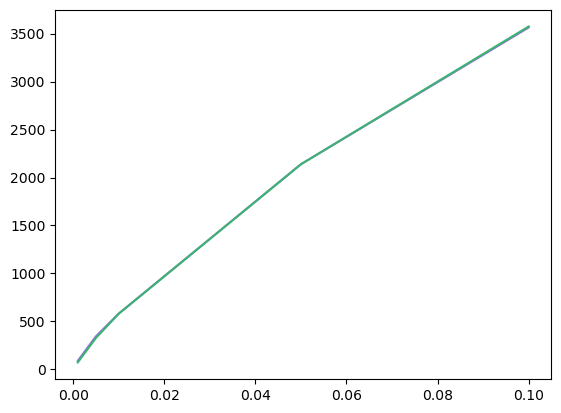

In [52]:
colors_dict = {
    "naive": "mediumpurple",
    "correlated": "mediumseagreen"
}
for pooling_strategy in ["naive", "correlated"]:
    plt.plot(
        list(agg_results[pooling_strategy].keys()),
        [x[0] for x in agg_results[pooling_strategy].values()],
        label=pooling_strategy,
        color = colors_dict[pooling_strategy]
    )

In [38]:
agg_results

defaultdict(<function __main__.defaultdict_list()>,
            {'naive': defaultdict(list,
                         {0.001: [89.0, 46.48225467853297],
                          0.005: [344.8, 51.32211998738945],
                          0.01: [581.9, 54.074855524541164],
                          0.05: [2138.4, 36.34886518173573],
                          0.1: [3564.0, 59.66238345892661]}),
             'correlated': defaultdict(list,
                         {0.001: [71.8, 27.82373087851448],
                          0.005: [328.0, 58.09302884167773],
                          0.01: [580.0, 46.00217386167745],
                          0.05: [2138.3, 24.066782086519172],
                          0.1: [3574.6, 60.031991471214745]})})

In [5]:
import pickle

pickle.load(
    open(
        "/home/yz685/corr_pooling_seirsplus/results/US_pop_size=10000_init_prev=0.1_num_groups=10_pool_size=5_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25/correlated/results_0.pickle",
        "rb")
)

[{'cum_positives_screened': 100,
  'cum_positives_identified': 0,
  'cum_sensitivity': 0.0,
  'cum_num_tests': 200,
  'day': 0,
  'cumRecovered': 0.0,
  'cumInfections': 1000.0,
  'mean_num_positives_in_positive_pool': 1.1627906976744187},
 {'cum_positives_screened': 220,
  'cum_positives_identified': 57,
  'cum_sensitivity': 0.2590909090909091,
  'cum_num_tests': 630,
  'day': 1,
  'cumRecovered': 2.0,
  'cumInfections': 1824.0,
  'mean_num_positives_in_positive_pool': 1.2371134020618557},
 {'cum_positives_screened': 476,
  'cum_positives_identified': 247,
  'cum_sensitivity': 0.5189075630252101,
  'cum_num_tests': 1240,
  'day': 2,
  'cumRecovered': 15.0,
  'cumInfections': 2276.0,
  'mean_num_positives_in_positive_pool': 2.9767441860465116},
 {'cum_positives_screened': 741,
  'cum_positives_identified': 485,
  'cum_sensitivity': 0.6545209176788124,
  'cum_num_tests': 1945,
  'day': 3,
  'cumRecovered': 69.0,
  'cumInfections': 2555.0,
  'mean_num_positives_in_positive_pool': 2.59803

In [35]:

N = 10000
INIT_EXPOSED = int(N * 0.01)
T=30



In [38]:

random.seed(0)
np.random.seed(0)

demographic_graphs, _, _ = generate_demographic_contact_network(
    N=N, 
    demographic_data=household_country_data('US'),
    distancing_scales=[0.7], 
    isolation_groups=[],
)

G = demographic_graphs['baseline']
# assign higher weights to inter-household edges
for e in G.edges():
    if "weight" not in G[e[0]][e[1]]:
        G[e[0]][e[1]]["weight"] = 10**10

test_model = ViralExtSEIRNetworkModel(
    G = G,
    beta = 0.5,
    sigma = 0.2,
    lamda = 0.5,
    gamma  = 0.25,
    seed = 0,
    initE = INIT_EXPOSED,
    transition_mode = "time_in_state",
)

sim_correlated = SimulationRunner(
    model=test_model,
    pooling_strategy='correlated',
    T = T,
    num_groups = 10,
    pool_size = 5,
    seed = 0,
    verbose=True,
    save_results=False,
    max_dt = 0.01
)

sim_correlated.run_simulation()



Generated overall age distribution:
0-9: 0.1179	(-0.0031 from target)
10-19: 0.1252	(-0.0058 from target)
20-29: 0.1423	(0.0053 from target)
30-39: 0.1343	(0.0013 from target)
40-49: 0.1211	(-0.0029 from target)
50-59: 0.1276	(-0.0034 from target)
60-69: 0.1152	(0.0002 from target)
70-79: 0.0743	(0.0043 from target)
80+: 0.0421	(0.0041 from target)

Generated household size distribution:
1: 0.3001	(0.0164 from target)
2: 0.3337	(-0.0114 from target)
3: 0.1442	(-0.0065 from target)
4: 0.1242	(-0.0034 from target)
5: 0.0614	(0.0036 from target)
6: 0.0222	(-0.0005 from target)
7: 0.0141	(0.0017 from target)
Num households: 4105
mean household size: 2.448393594

Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


Running simulation with seed 0 for strategy correlated...
Running screening for group 0 on day 0...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


Screening day:  0  self.model.t:  0.01
Running screening for group 1 on day 1...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Screening day:  1  self.model.t:  1.0000000000000007
{'t': 1.0600117958973134, 'transitionNode': 5061, 'transitionNodeVL': 7.829963946651142, 'transitionType': 'EtoIPRE'}
{'t': 1.0600117961626543, 'transitionNode': 1831, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
Running screening for group 2 on day 2...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Screening day:  2  self.model.t:  2.0600117961626543
{'t': 2.0600119105697057, 'transitionNode': 5532, 'transitionNodeVL': 6.8555517284067085, 'transitionType': 'EtoIPRE'}
{'t': 2.0600119107594734, 'transitionNode': 1943, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 2.060011950397816, 'transitionNode': 5721, 'transitionNodeVL': 8.158363337515949, 'transitionType': 'EtoIPRE'}
{'t': 2.0600119505718095, 'transitionNode': 1987, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 2.060012170780265, 'transitionNode': 887, 'transitionNodeVL': 8.73336060238277, 'transitionType': 'EtoIPRE'}
{'t': 2.060012526617503, 'transitionNode': 5255, 'transitionNodeVL': 8.030562073805465, 'transitionType': 'EtoIPRE'}
{'t': 2.0600125268012595, 'transitionNode': 5256, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 2.060012576499555, 'transitionNode': 3077, 'transitionNodeVL': 9.79847247503899, 'transitionType': 'EtoIPRE'}
{'t': 2.0600127644755153, 'transitionNode': 8769, 'transitio

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


Screening day:  3  self.model.t:  3.0047247359587974
{'t': 3.0047247510609623, 'transitionNode': 9973, 'transitionNodeVL': 8.625944933772145, 'transitionType': 'EtoIPRE'}
{'t': 3.0047252984450767, 'transitionNode': 6424, 'transitionNodeVL': 8.491020452884491, 'transitionType': 'EtoIPRE'}
{'t': 3.004725298593785, 'transitionNode': 6425, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 3.0047252993834905, 'transitionNode': 9456, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 3.0047252994271902, 'transitionNode': 6423, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 3.004726244830819, 'transitionNode': 9324, 'transitionNodeVL': 8.799425540490434, 'transitionType': 'EtoIPRE'}
{'t': 3.0047262448951906, 'transitionNode': 851, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 3.00472624499361, 'transitionNode': 850, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 3.0047262454792474, 'transitionNode': 849, 'transitionNodeVL': 0.0, 'transitionType': 'S

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Screening day:  4  self.model.t:  4.100127402881768
{'t': 4.100127707726611, 'transitionNode': 284, 'transitionNodeVL': 8.266031957940386, 'transitionType': 'EtoIPRE'}
{'t': 4.1001304005392125, 'transitionNode': 4025, 'transitionNodeVL': 8.566673056773311, 'transitionType': 'EtoIPRE'}
{'t': 4.100130847389378, 'transitionNode': 9181, 'transitionNodeVL': 8.144823703815018, 'transitionType': 'QEtoQPRE'}
{'t': 4.100131480567231, 'transitionNode': 9213, 'transitionNodeVL': 6.86710562713502, 'transitionType': 'EtoIPRE'}
{'t': 4.100131594694828, 'transitionNode': 7634, 'transitionNodeVL': 5.2996786327533965, 'transitionType': 'QEtoQPRE'}
{'t': 4.100131807004959, 'transitionNode': 8310, 'transitionNodeVL': 6.4879259074860265, 'transitionType': 'QPREtoQSYM'}
{'t': 4.100132551314812, 'transitionNode': 3432, 'transitionNodeVL': 5.6305938534345845, 'transitionType': 'EtoIPRE'}
{'t': 4.100138782061566, 'transitionNode': 3201, 'transitionNodeVL': 8.520519185532242, 'transitionType': 'QEtoQPRE'}
{'t'

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Screening day:  5  self.model.t:  5.054039365877373
{'t': 5.0540395586803974, 'transitionNode': 3110, 'transitionNodeVL': 9.996427329282394, 'transitionType': 'EtoIPRE'}
{'t': 5.054039821479941, 'transitionNode': 6583, 'transitionNodeVL': 8.105894210945126, 'transitionType': 'QEtoQPRE'}
{'t': 5.054040058456698, 'transitionNode': 2048, 'transitionNodeVL': 9.496345138716652, 'transitionType': 'EtoIPRE'}
{'t': 5.054042637706868, 'transitionNode': 4070, 'transitionNodeVL': 8.00202437936234, 'transitionType': 'EtoIPRE'}
{'t': 5.054049719042424, 'transitionNode': 3433, 'transitionNodeVL': 8.513538103832772, 'transitionType': 'EtoIPRE'}
{'t': 5.054050031058248, 'transitionNode': 3076, 'transitionNodeVL': 7.8936379327316155, 'transitionType': 'IPREtoISYM'}
{'t': 5.054051258459464, 'transitionNode': 3838, 'transitionNodeVL': 8.53379088975737, 'transitionType': 'EtoIPRE'}
{'t': 5.054057171456598, 'transitionNode': 4071, 'transitionNodeVL': 9.188085835730611, 'transitionType': 'EtoIPRE'}
{'t': 5.

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


Screening day:  6  self.model.t:  6.085495071523324
{'t': 6.085495287229565, 'transitionNode': 849, 'transitionNodeVL': 6.011554053257072, 'transitionType': 'QEtoQPRE'}
{'t': 6.085495459424086, 'transitionNode': 3071, 'transitionNodeVL': 8.666032861356886, 'transitionType': 'QEtoQPRE'}
{'t': 6.0854954979645175, 'transitionNode': 5920, 'transitionNodeVL': 9.141068362486086, 'transitionType': 'IPREtoISYM'}
{'t': 6.085495690462485, 'transitionNode': 7737, 'transitionNodeVL': 7.999676077425268, 'transitionType': 'IPREtoISYM'}
{'t': 6.085495917699628, 'transitionNode': 5062, 'transitionNodeVL': 8.006701249143651, 'transitionType': 'EtoIPRE'}
{'t': 6.085496049087865, 'transitionNode': 5569, 'transitionNodeVL': 9.072568787604773, 'transitionType': 'EtoIPRE'}
{'t': 6.085496539209447, 'transitionNode': 1279, 'transitionNodeVL': 9.386620192996535, 'transitionType': 'QPREtoQSYM'}
{'t': 6.0854978440995895, 'transitionNode': 1831, 'transitionNodeVL': 8.999617683082272, 'transitionType': 'IPREtoISYM

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


Screening day:  7  self.model.t:  7.033804789134736
{'t': 7.033806066250682, 'transitionNode': 6809, 'transitionNodeVL': 6.729511400815475, 'transitionType': 'IPREtoISYM'}
{'t': 7.033806873091335, 'transitionNode': 1613, 'transitionNodeVL': 7.573273339757553, 'transitionType': 'QPREtoQSYM'}
{'t': 7.033806918514408, 'transitionNode': 7953, 'transitionNodeVL': 8.190432193851953, 'transitionType': 'QPREtoQSYM'}
{'t': 7.033807297660387, 'transitionNode': 92, 'transitionNodeVL': 8.03493827536474, 'transitionType': 'IPREtoISYM'}
{'t': 7.033808160728473, 'transitionNode': 1660, 'transitionNodeVL': 5.630547471193433, 'transitionType': 'IPREtoISYM'}
{'t': 7.033808689480702, 'transitionNode': 4819, 'transitionNodeVL': 7.613785825593011, 'transitionType': 'EtoIPRE'}
{'t': 7.033809187388658, 'transitionNode': 3386, 'transitionNodeVL': 8.084156228044158, 'transitionType': 'IPREtoISYM'}
{'t': 7.033812206432715, 'transitionNode': 5874, 'transitionNodeVL': 8.324112120339612, 'transitionType': 'QPREtoQ

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Screening day:  8  self.model.t:  8.079102287500858
{'t': 8.079103869414006, 'transitionNode': 2787, 'transitionNodeVL': 9.666946231778967, 'transitionType': 'QPREtoQSYM'}
{'t': 8.079105395214102, 'transitionNode': 7952, 'transitionNodeVL': 6.8150874231199685, 'transitionType': 'QPREtoQSYM'}
{'t': 8.079106160828854, 'transitionNode': 9968, 'transitionNodeVL': 6.5999023787655045, 'transitionType': 'QPREtoQSYM'}
{'t': 8.079106434275952, 'transitionNode': 1911, 'transitionNodeVL': 9.830378329349152, 'transitionType': 'QPREtoQSYM'}
{'t': 8.079106786134579, 'transitionNode': 4817, 'transitionNodeVL': 6.250009705831606, 'transitionType': 'EtoIPRE'}
{'t': 8.079107051779296, 'transitionNode': 3218, 'transitionNodeVL': 6.615386694436934, 'transitionType': 'EtoIPRE'}
{'t': 8.079107082908786, 'transitionNode': 851, 'transitionNodeVL': 9.59417471779802, 'transitionType': 'QPREtoQSYM'}
{'t': 8.07910839302724, 'transitionNode': 6356, 'transitionNodeVL': 8.673709028488293, 'transitionType': 'IPREtoIS

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


Screening day:  9  self.model.t:  9.078750647941998
{'t': 9.07875074532314, 'transitionNode': 2496, 'transitionNodeVL': 5.252434656790118, 'transitionType': 'EtoIPRE'}
{'t': 9.078751131370003, 'transitionNode': 3071, 'transitionNodeVL': 8.499471693637817, 'transitionType': 'QPREtoQSYM'}
{'t': 9.078751602625966, 'transitionNode': 6425, 'transitionNodeVL': 5.149286874390569, 'transitionType': 'IPREtoISYM'}
{'t': 9.078752097433963, 'transitionNode': 5064, 'transitionNodeVL': 8.006538296783571, 'transitionType': 'IPREtoISYM'}
{'t': 9.078752483291876, 'transitionNode': 6962, 'transitionNodeVL': 5.299795455109476, 'transitionType': 'IPREtoISYM'}
{'t': 9.078754317614925, 'transitionNode': 3452, 'transitionNodeVL': 6.646390054079204, 'transitionType': 'EtoIPRE'}
{'t': 9.07875990978416, 'transitionNode': 2979, 'transitionNodeVL': 8.327770471439148, 'transitionType': 'QPREtoQSYM'}
{'t': 9.078763394588488, 'transitionNode': 4562, 'transitionNodeVL': 8.112170339601851, 'transitionType': 'EtoIPRE'}

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


Screening day:  10  self.model.t:  10.021470085736093
{'t': 10.021477951943076, 'transitionNode': 7477, 'transitionNodeVL': 7.581160629533691, 'transitionType': 'EtoIPRE'}
{'t': 10.123050329731868, 'transitionNode': 3450, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 10.123053142033339, 'transitionNode': 3348, 'transitionNodeVL': 8.137020115202823, 'transitionType': 'IPREtoISYM'}
{'t': 10.123053400360474, 'transitionNode': 6439, 'transitionNodeVL': 6.318681665262668, 'transitionType': 'IPREtoISYM'}
{'t': 10.123058675999552, 'transitionNode': 4031, 'transitionNodeVL': 8.92221229499011, 'transitionType': 'IPREtoISYM'}
{'t': 10.1230670488228, 'transitionNode': 7987, 'transitionNodeVL': 9.010156906977311, 'transitionType': 'IPREtoISYM'}
{'t': 10.144750331724225, 'transitionNode': 5117, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 10.446202329575051, 'transitionNode': 3428, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 10.446202498244556, 'transitionNode': 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


Screening day:  11  self.model.t:  11.030815365095581
{'t': 11.030849244082674, 'transitionNode': 2580, 'transitionNodeVL': 8.332744024835266, 'transitionType': 'QPREtoQSYM'}
{'t': 11.071362831896606, 'transitionNode': 7194, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 11.071363129140043, 'transitionNode': 8339, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 11.07136671402916, 'transitionNode': 9971, 'transitionNodeVL': 0.0, 'transitionType': 'ISYMtoR'}
{'t': 11.071368263322686, 'transitionNode': 8310, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 11.071369175746769, 'transitionNode': 5139, 'transitionNodeVL': 5.911481940695311, 'transitionType': 'QEtoQPRE'}
{'t': 11.07137507391698, 'transitionNode': 5532, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 11.071376371110343, 'transitionNode': 5837, 'transitionNodeVL': 0.0, 'transitionType': 'ISYMtoR'}
{'t': 11.111897758263188, 'transitionNode': 3905, 'transitionNodeVL': 0.0, 'transiti

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Screening day:  12  self.model.t:  12.166149343658326
{'t': 12.166149575825042, 'transitionNode': 2079, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 12.166149832145845, 'transitionNode': 4817, 'transitionNodeVL': 6.081655805848014, 'transitionType': 'QPREtoQSYM'}
{'t': 12.166150269881232, 'transitionNode': 6008, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 12.166150707482164, 'transitionNode': 3473, 'transitionNodeVL': 7.921925209949123, 'transitionType': 'EtoIPRE'}
{'t': 12.166151586982645, 'transitionNode': 3670, 'transitionNodeVL': 7.951196553402364, 'transitionType': 'QEtoQPRE'}
{'t': 12.166154612350649, 'transitionNode': 3678, 'transitionNodeVL': 5.085071988058929, 'transitionType': 'EtoIPRE'}
{'t': 12.16615509767767, 'transitionNode': 5784, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 12.166157210512692, 'transitionNode': 6841, 'transitionNodeVL': 9.436715614005422, 'transitionType': 'EtoIPRE'}
{'t': 12.166157679198992, 'transitionN

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


Screening day:  13  self.model.t:  13.111461169560444
{'t': 13.111462831559718, 'transitionNode': 5181, 'transitionNodeVL': 8.87100076613074, 'transitionType': 'QPREtoQSYM'}
{'t': 13.11146727301671, 'transitionNode': 3905, 'transitionNodeVL': 5.005722142256593, 'transitionType': 'EtoIPRE'}
{'t': 13.111468106373103, 'transitionNode': 3428, 'transitionNodeVL': 8.877924838880668, 'transitionType': 'EtoIPRE'}
{'t': 13.111468374212212, 'transitionNode': 5559, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 13.111471629366639, 'transitionNode': 3432, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 13.111475229576186, 'transitionNode': 2284, 'transitionNodeVL': 0.0, 'transitionType': 'ISYMtoR'}
{'t': 13.111476706018996, 'transitionNode': 3112, 'transitionNodeVL': 0.0, 'transitionType': 'ISYMtoR'}
{'t': 13.11151051578446, 'transitionNode': 2496, 'transitionNodeVL': 5.165320730587357, 'transitionType': 'QPREtoQSYM'}
{'t': 13.259741885531671, 'transitionNode': 5506, 'tr

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Screening day:  14  self.model.t:  14.03585960514566
{'t': 14.035863321751279, 'transitionNode': 3825, 'transitionNodeVL': 8.911175455242002, 'transitionType': 'QPREtoQSYM'}
{'t': 14.035879566369173, 'transitionNode': 9143, 'transitionNodeVL': 8.071591838273312, 'transitionType': 'EtoIPRE'}
{'t': 14.044150593673143, 'transitionNode': 6732, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 14.044152575295616, 'transitionNode': 850, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 14.044170078677352, 'transitionNode': 617, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 14.120818622530862, 'transitionNode': 3714, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 14.120820294615635, 'transitionNode': 8876, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 14.120820816718396, 'transitionNode': 4629, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 14.12082181519254, 'transitionNode': 4899, 'transitionNodeVL': 0.0, 'transitionTyp

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


Screening day:  15  self.model.t:  15.03694649348566
{'t': 15.036954346104682, 'transitionNode': 6748, 'transitionNodeVL': 5.751492857357901, 'transitionType': 'IPREtoISYM'}
{'t': 15.09643000413442, 'transitionNode': 3541, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 15.111174384571745, 'transitionNode': 4601, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 15.111178191823178, 'transitionNode': 5139, 'transitionNodeVL': 5.886764664149927, 'transitionType': 'QPREtoQSYM'}
{'t': 15.328814420787225, 'transitionNode': 3779, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 15.32881442958263, 'transitionNode': 5506, 'transitionNodeVL': 8.136551929090672, 'transitionType': 'EtoIPRE'}
{'t': 15.328814946781716, 'transitionNode': 2817, 'transitionNodeVL': 6.96602516908702, 'transitionType': 'EtoIPRE'}
{'t': 15.328815186072676, 'transitionNode': 6174, 'transitionNodeVL': 5.2066760450421485, 'transitionType': 'QPREtoQSYM'}
{'t': 15.328818388478789, 'transitionNode': 550

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Screening day:  16  self.model.t:  16.18110317119111
{'t': 16.181103512946137, 'transitionNode': 4072, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 16.18110359539674, 'transitionNode': 2851, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 16.18110373777563, 'transitionNode': 5033, 'transitionNodeVL': 6.7031464081794425, 'transitionType': 'EtoIPRE'}
{'t': 16.181104054477924, 'transitionNode': 3678, 'transitionNodeVL': 4.982001272068622, 'transitionType': 'IPREtoISYM'}
{'t': 16.18110512563731, 'transitionNode': 2737, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 16.181105382669923, 'transitionNode': 4552, 'transitionNodeVL': 9.39639793309045, 'transitionType': 'IPREtoISYM'}
{'t': 16.18110633616668, 'transitionNode': 8877, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 16.18110825407833, 'transitionNode': 3714, 'transitionNodeVL': 9.622388250118387, 'transitionType': 'EtoIPRE'}
{'t': 16.181108553675692, 'transitionNode': 7814, 'tra

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Screening day:  17  self.model.t:  17.10355963586495
{'t': 17.103563536787362, 'transitionNode': 2112, 'transitionNodeVL': 0.0, 'transitionType': 'ISYMtoR'}
{'t': 17.10356478224189, 'transitionNode': 9969, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 17.103565471199285, 'transitionNode': 3779, 'transitionNodeVL': 6.995144716410605, 'transitionType': 'EtoIPRE'}
{'t': 17.103571413833457, 'transitionNode': 7050, 'transitionNodeVL': 8.388105558160667, 'transitionType': 'IPREtoISYM'}
{'t': 17.103573437676445, 'transitionNode': 6134, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 17.103589497368493, 'transitionNode': 2617, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 17.122540284687577, 'transitionNode': 4482, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 17.122544305145112, 'transitionNode': 9324, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 17.147761467501706, 'transitionNode': 6231, 'transitionNodeVL': 0.0, 'transiti

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Screening day:  18  self.model.t:  18.280906996829806
{'t': 18.280907491959507, 'transitionNode': 3821, 'transitionNodeVL': 9.017673409602345, 'transitionType': 'IPREtoISYM'}
{'t': 18.28090791445396, 'transitionNode': 5124, 'transitionNodeVL': 9.553806223975204, 'transitionType': 'IPREtoISYM'}
{'t': 18.280908271880495, 'transitionNode': 6435, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 18.280909518125032, 'transitionNode': 5740, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 18.28090971784019, 'transitionNode': 284, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 18.280910111679642, 'transitionNode': 3933, 'transitionNodeVL': 8.314634370960503, 'transitionType': 'EtoIPRE'}
{'t': 18.280910505206098, 'transitionNode': 5874, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 18.280910664067907, 'transitionNode': 2705, 'transitionNodeVL': 7.96011958645317, 'transitionType': 'IPREtoISYM'}
{'t': 18.28091104051577, 'transitionNode': 3848, 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


Screening day:  19  self.model.t:  19.077305226640828
{'t': 19.077305548011406, 'transitionNode': 3826, 'transitionNodeVL': 8.571101547628976, 'transitionType': 'EtoIPRE'}
{'t': 19.077305999705217, 'transitionNode': 4699, 'transitionNodeVL': 5.855920642157018, 'transitionType': 'IPREtoISYM'}
{'t': 19.077306995340344, 'transitionNode': 6356, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 19.077307786597796, 'transitionNode': 6869, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 19.0773088199082, 'transitionNode': 4876, 'transitionNodeVL': 5.625127488387527, 'transitionType': 'IPREtoISYM'}
{'t': 19.077309424732274, 'transitionNode': 4673, 'transitionNodeVL': 9.739992977945466, 'transitionType': 'EtoIPRE'}
{'t': 19.07731438196795, 'transitionNode': 1943, 'transitionNodeVL': 0.0, 'transitionType': 'ISYMtoR'}
{'t': 19.162012034471264, 'transitionNode': 5885, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 19.16201292994479, 'transitionNode': 7246, 'transi

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


Screening day:  20  self.model.t:  20.26797875059693
{'t': 20.267979439077575, 'transitionNode': 2819, 'transitionNodeVL': 9.486693293434248, 'transitionType': 'EtoIPRE'}
{'t': 20.26798054499238, 'transitionNode': 3749, 'transitionNodeVL': 9.602240881877123, 'transitionType': 'IPREtoISYM'}
{'t': 20.267980691281423, 'transitionNode': 3723, 'transitionNodeVL': 7.722954355276113, 'transitionType': 'EtoIPRE'}
{'t': 20.26798157646914, 'transitionNode': 3832, 'transitionNodeVL': 9.270031742510552, 'transitionType': 'IPREtoISYM'}
{'t': 20.267981770527783, 'transitionNode': 5898, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 20.267982188781904, 'transitionNode': 3375, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 20.267982809238603, 'transitionNode': 3779, 'transitionNodeVL': 6.902928467469213, 'transitionType': 'IPREtoISYM'}
{'t': 20.267982872842026, 'transitionNode': 3540, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 20.267985042417173, 'transiti

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.50it/s]


Screening day:  21  self.model.t:  21.118300167253228
{'t': 21.118306503013255, 'transitionNode': 5103, 'transitionNodeVL': 6.700467813861915, 'transitionType': 'QEtoQPRE'}
{'t': 21.11830683137186, 'transitionNode': 3933, 'transitionNodeVL': 8.262584905873526, 'transitionType': 'QPREtoQSYM'}
{'t': 21.118308031356673, 'transitionNode': 5173, 'transitionNodeVL': 6.689257875632636, 'transitionType': 'QEtoQPRE'}
{'t': 21.118309265143616, 'transitionNode': 4031, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 21.118312356753687, 'transitionNode': 3929, 'transitionNodeVL': 6.967591544136388, 'transitionType': 'QEtoQPRE'}
{'t': 21.118312463792464, 'transitionNode': 4601, 'transitionNodeVL': 7.5355071965696725, 'transitionType': 'QPREtoQSYM'}
{'t': 21.118316402411445, 'transitionNode': 3957, 'transitionNodeVL': 9.906455193306675, 'transitionType': 'QEtoQPRE'}
{'t': 21.118317805179167, 'transitionNode': 5894, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 21.118323027

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Screening day:  22  self.model.t:  22.009903446195825
{'t': 22.00990358705503, 'transitionNode': 9498, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 22.00990397572959, 'transitionNode': 7144, 'transitionNodeVL': 0.0, 'transitionType': 'ISYMtoR'}
{'t': 22.009907982275188, 'transitionNode': 4944, 'transitionNodeVL': 8.230980505366576, 'transitionType': 'QPREtoQSYM'}
{'t': 22.00991193898785, 'transitionNode': 5296, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 22.009913934956675, 'transitionNode': 3806, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 22.009919625740952, 'transitionNode': 3968, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 22.009921544973437, 'transitionNode': 4929, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 22.009923211489017, 'transitionNode': 4803, 'transitionNodeVL': 6.056134350671584, 'transitionType': 'QPREtoQSYM'}
{'t': 22.00992679245519, 'transitionNode': 4673, 'transitionNodeVL': 9.7259969

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


Screening day:  23  self.model.t:  23.309072134345175
{'t': 23.309073206586532, 'transitionNode': 6187, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 23.309073691033042, 'transitionNode': 1244, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 23.309075233832772, 'transitionNode': 3700, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 23.309075256275044, 'transitionNode': 4288, 'transitionNodeVL': 5.991033662452336, 'transitionType': 'EtoIPRE'}
{'t': 23.309075481368563, 'transitionNode': 4111, 'transitionNodeVL': 9.44687453710331, 'transitionType': 'EtoIPRE'}
{'t': 23.30907576173602, 'transitionNode': 3917, 'transitionNodeVL': 5.981184069323072, 'transitionType': 'QPREtoQSYM'}
{'t': 23.30907609452862, 'transitionNode': 2775, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 23.309076438915774, 'transitionNode': 3660, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 23.309077496754842, 'transitionNode': 4554, 'transitionNodeVL

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Screening day:  24  self.model.t:  24.237985644453538
{'t': 24.237987516044964, 'transitionNode': 6513, 'transitionNodeVL': 8.495218332626878, 'transitionType': 'QPREtoQSYM'}
{'t': 24.237990126335223, 'transitionNode': 3399, 'transitionNodeVL': 7.540241024093792, 'transitionType': 'EtoIPRE'}
{'t': 24.237998486686127, 'transitionNode': 5288, 'transitionNodeVL': 9.554883078922268, 'transitionType': 'QPREtoQSYM'}
{'t': 24.23799991709172, 'transitionNode': 3772, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 24.23801141726786, 'transitionNode': 3887, 'transitionNodeVL': 8.887268085557048, 'transitionType': 'QPREtoQSYM'}
{'t': 24.238015466592447, 'transitionNode': 9210, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 24.23804676575918, 'transitionNode': 6629, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 24.787218318134702, 'transitionNode': 3893, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 24.787219023003097, 'transitionNode': 7903, 't

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Screening day:  25  self.model.t:  25.994594765532995
{'t': 25.994595075810114, 'transitionNode': 4699, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 25.994595847169272, 'transitionNode': 6158, 'transitionNodeVL': 0.0, 'transitionType': 'ISYMtoR'}
{'t': 25.994596589442484, 'transitionNode': 3086, 'transitionNodeVL': 9.018915846594476, 'transitionType': 'EtoIPRE'}
{'t': 25.994596980958423, 'transitionNode': 3473, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 25.99459814662916, 'transitionNode': 5103, 'transitionNodeVL': 6.0554024586682385, 'transitionType': 'QPREtoQSYM'}
{'t': 25.994598797119313, 'transitionNode': 7814, 'transitionNodeVL': 0.0, 'transitionType': 'ISYMtoR'}
{'t': 25.994599647711315, 'transitionNode': 2556, 'transitionNodeVL': 8.787249709722406, 'transitionType': 'QPREtoQSYM'}
{'t': 25.994600124178625, 'transitionNode': 6651, 'transitionNodeVL': 0.0, 'transitionType': 'ISYMtoR'}
{'t': 25.99460073678616, 'transitionNode': 4341, 'transitionNode

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


Screening day:  26  self.model.t:  26.10148141418261
{'t': 26.101485066207296, 'transitionNode': 4796, 'transitionNodeVL': 5.885214275163308, 'transitionType': 'EtoIPRE'}
{'t': 26.402608878103067, 'transitionNode': 6684, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 26.402609612834002, 'transitionNode': 5763, 'transitionNodeVL': 8.939773096416348, 'transitionType': 'EtoIPRE'}
{'t': 26.402610216184932, 'transitionNode': 5206, 'transitionNodeVL': 6.20506628647494, 'transitionType': 'IPREtoISYM'}
{'t': 26.40261414255117, 'transitionNode': 3670, 'transitionNodeVL': 0.0, 'transitionType': 'ISYMtoR'}
{'t': 26.402616679570954, 'transitionNode': 2431, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 26.402617088730306, 'transitionNode': 5828, 'transitionNodeVL': 6.18543174283108, 'transitionType': 'IPREtoISYM'}
{'t': 26.40261860125941, 'transitionNode': 4573, 'transitionNodeVL': 5.790827245022767, 'transitionType': 'EtoIPRE'}
{'t': 26.40262227706013, 'transitionNode': 34

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Screening day:  27  self.model.t:  27.178762211813325
{'t': 27.178763910636828, 'transitionNode': 3428, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 27.178768124598673, 'transitionNode': 4921, 'transitionNodeVL': 5.005097186535227, 'transitionType': 'IPREtoISYM'}
{'t': 27.178771406417535, 'transitionNode': 7050, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 27.178787021363032, 'transitionNode': 4729, 'transitionNodeVL': 7.9055443480229695, 'transitionType': 'IPREtoISYM'}
{'t': 27.67805554856797, 'transitionNode': 5075, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 27.67805666601138, 'transitionNode': 5049, 'transitionNodeVL': 8.420632483217483, 'transitionType': 'IPREtoISYM'}
{'t': 27.678056682508508, 'transitionNode': 4632, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 27.6780569454099, 'transitionNode': 2597, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 27.678057716955138, 'transitionNode': 3036, 'transitionNode

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Screening day:  28  self.model.t:  28.218999459338693
{'t': 28.219000163214677, 'transitionNode': 4541, 'transitionNodeVL': 5.691855767531778, 'transitionType': 'EtoIPRE'}
{'t': 28.219003792464086, 'transitionNode': 4552, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 28.219006552721176, 'transitionNode': 3222, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 28.219007078613238, 'transitionNode': 2506, 'transitionNodeVL': 8.882491684793978, 'transitionType': 'IPREtoISYM'}
{'t': 28.219012509470684, 'transitionNode': 2821, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 28.21901829852966, 'transitionNode': 2494, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 28.219023400207426, 'transitionNode': 5251, 'transitionNodeVL': 8.169007310538316, 'transitionType': 'IPREtoISYM'}
{'t': 28.219025791534936, 'transitionNode': 4678, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 28.384578173734393, 'transitionNode': 4922, 'transitionN

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Screening day:  29  self.model.t:  29.388966173989214
{'t': 29.388969609408846, 'transitionNode': 4573, 'transitionNodeVL': 5.702362104528183, 'transitionType': 'IPREtoISYM'}
{'t': 29.388969874918388, 'transitionNode': 3498, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 29.388973718423774, 'transitionNode': 3709, 'transitionNodeVL': 6.522942510021648, 'transitionType': 'EtoIPRE'}
{'t': 29.388977513391765, 'transitionNode': 3821, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 29.388981558496788, 'transitionNode': 6405, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 29.388987583503233, 'transitionNode': 3882, 'transitionNodeVL': 0.0, 'transitionType': 'QSYMtoQR'}
{'t': 29.389039711406532, 'transitionNode': 7246, 'transitionNodeVL': 0.0, 'transitionType': 'ISYMtoR'}
{'t': 30.34078902257292, 'transitionNode': 3996, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}


In [39]:

random.seed(0)
np.random.seed(0)

demographic_graphs, _, _ = generate_demographic_contact_network(
    N=N, 
    demographic_data=household_country_data('US'),
    distancing_scales=[0.7], 
    isolation_groups=[],
)

G = demographic_graphs['baseline']
# assign higher weights to inter-household edges
for e in G.edges():
    if "weight" not in G[e[0]][e[1]]:
        G[e[0]][e[1]]["weight"] = 10**10

test_model = ViralExtSEIRNetworkModel(
    G = G,
    beta = 0.5,
    sigma = 0.2,
    lamda = 0.5,
    gamma  = 0.25,
    seed = 0,
    initE = INIT_EXPOSED,
    transition_mode = "time_in_state",
)

sim_naive = SimulationRunner(
    model=test_model,
    pooling_strategy='naive',
    T = T,
    num_groups = 10,
    pool_size = 5,
    seed = 0,
    verbose=True,
    save_results=False,
    max_dt = 1
)

sim_naive.run_simulation()



Generated overall age distribution:
0-9: 0.1179	(-0.0031 from target)
10-19: 0.1252	(-0.0058 from target)
20-29: 0.1423	(0.0053 from target)
30-39: 0.1343	(0.0013 from target)
40-49: 0.1211	(-0.0029 from target)
50-59: 0.1276	(-0.0034 from target)
60-69: 0.1152	(0.0002 from target)
70-79: 0.0743	(0.0043 from target)
80+: 0.0421	(0.0041 from target)

Generated household size distribution:
1: 0.3001	(0.0164 from target)
2: 0.3337	(-0.0114 from target)
3: 0.1442	(-0.0065 from target)
4: 0.1242	(-0.0034 from target)
5: 0.0614	(0.0036 from target)
6: 0.0222	(-0.0005 from target)
7: 0.0141	(0.0017 from target)
Num households: 4105
mean household size: 2.448393594

Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:28<00:00,  2.89s/it]


Running simulation with seed 0 for strategy naive...
Running screening for group 0 on day 0...
Screening day:  0  self.model.t:  0.01
Running screening for group 1 on day 1...
Screening day:  1  self.model.t:  1.0000000000000007
{'t': 1.0600026591957927, 'transitionNode': 5061, 'transitionNodeVL': 7.829963946651142, 'transitionType': 'EtoIPRE'}
{'t': 1.0600026592515184, 'transitionNode': 1831, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
Running screening for group 2 on day 2...
Screening day:  2  self.model.t:  2.060002659251518
{'t': 2.0600027055065757, 'transitionNode': 2334, 'transitionNodeVL': 9.672008281863166, 'transitionType': 'QEtoQPRE'}
{'t': 2.060002705778082, 'transitionNode': 2333, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
{'t': 2.0600027400183807, 'transitionNode': 7898, 'transitionNodeVL': 8.320128465884212, 'transitionType': 'EtoIPRE'}
{'t': 2.0600028175328213, 'transitionNode': 931, 'transitionNodeVL': 8.42246440256956, 'transitionType': 'EtoIPRE'}
{'t':

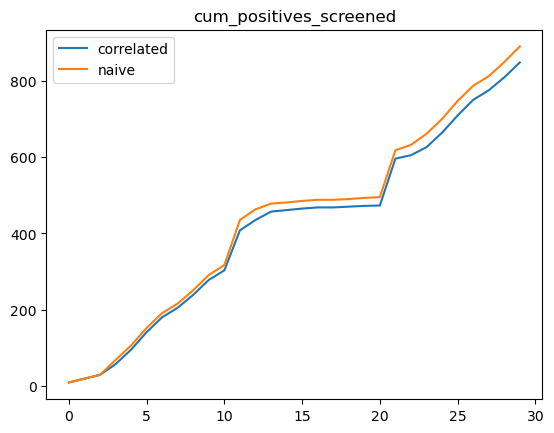

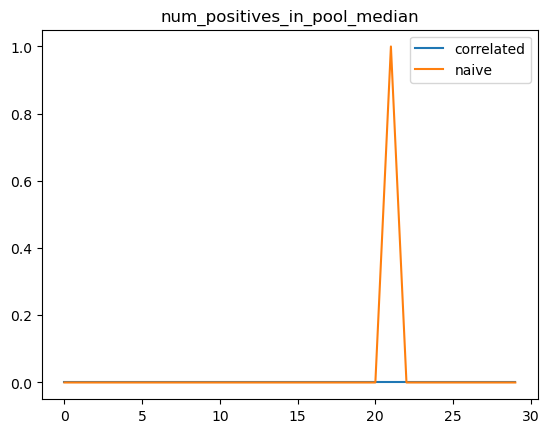

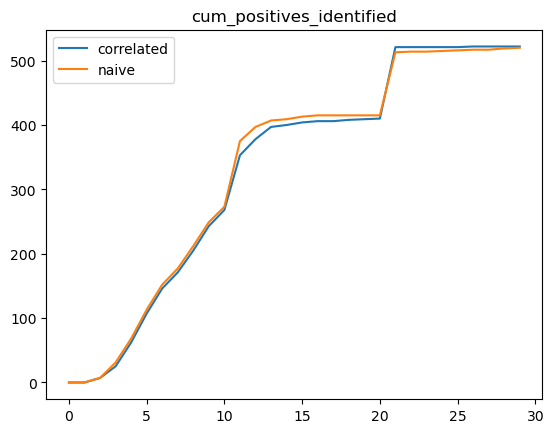

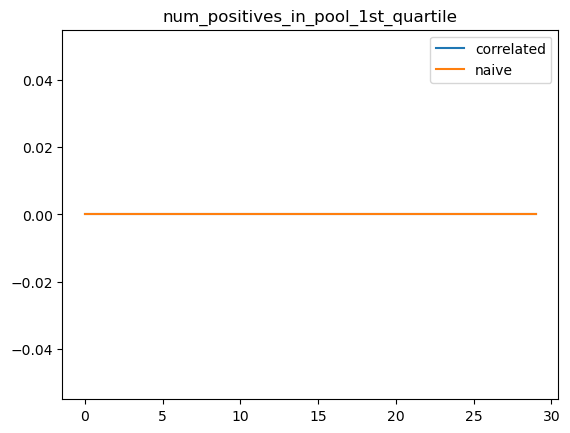

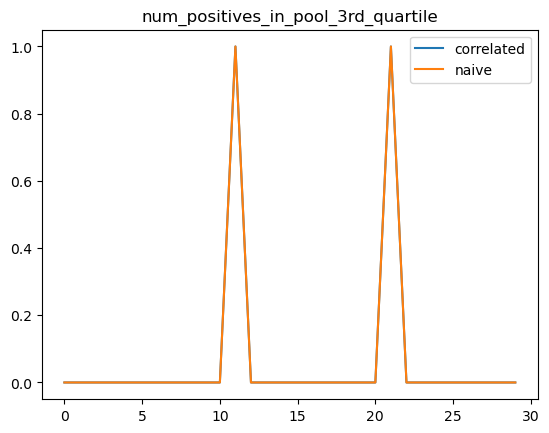

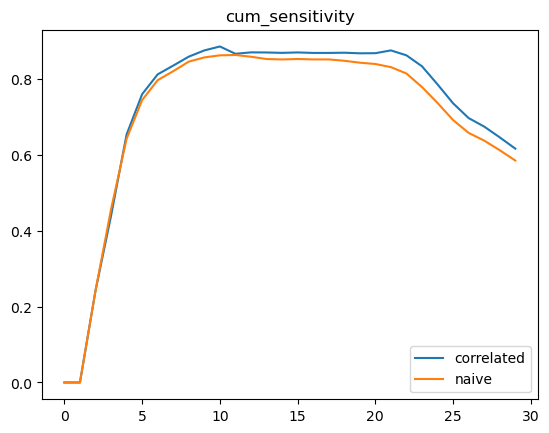

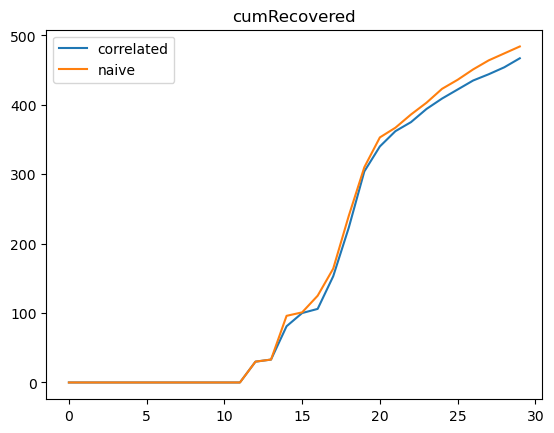

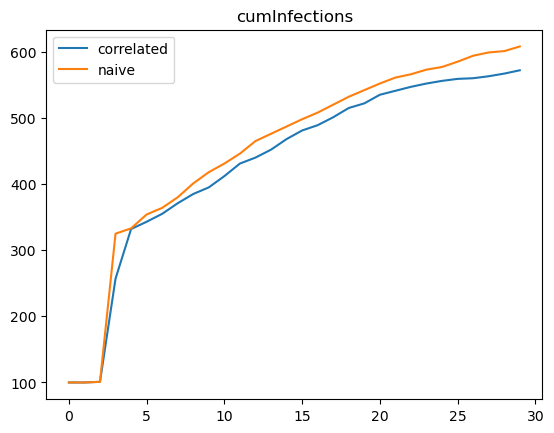

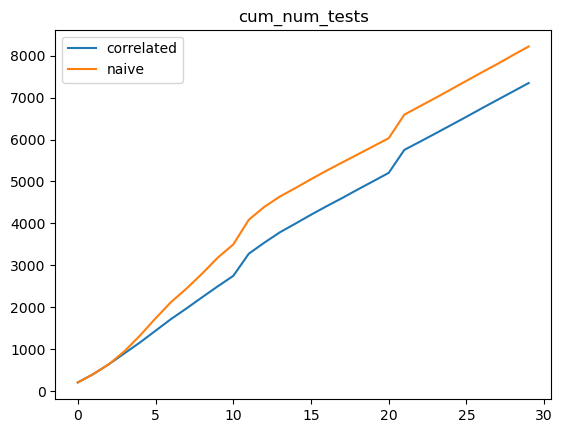

In [41]:
metrics = sim_correlated.overall_results[0].keys()
metrics = set(metrics) - {"day"}

for metric in metrics:
    plt.plot([result[metric] for result in sim_correlated.overall_results])
    plt.plot([result[metric] for result in sim_naive.overall_results])
    plt.title(metric)
    plt.legend(['correlated', 'naive'])
    plt.show()

In [3]:
list(filter(
    lambda x: x>0,
    [0,0,0]
)
)

[]

In [5]:
import numpy as np
np.mean([])

/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


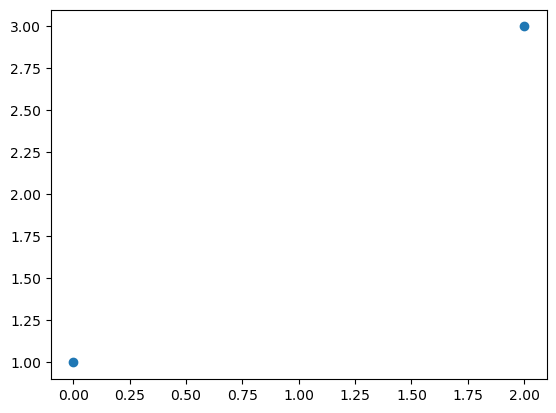

In [9]:
import matplotlib.pyplot as plt

plt.scatter(
    [0,1,2],
    [1, np.mean([]), 3]
)